In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
#import imutils
import copy

CAMERA=0
PORTS=3
CAL_PARAM = {'thresh': [65,100],
            'radius': [4, 9]}

def capture_pic(camera = CAMERA, rotation = 0):
    '''Capture a picture from camera.
    
    Args:
        name (str):     The name of picture
        camera (int):   Camera number (Use check_camera() to find correct camera
        rotation(int):  Number of anti-clockwise rotations for image
    
    Returns:
        bool: True if successful, False otherwise
    '''
    try:
        cap = cv2.VideoCapture(camera)
        # Capture frame-by-frame
        ret, frame = cap.read()
    
        frame = np.rot90(frame, rotation)
    # Display the resulting frame
        #cv2.imwrite(name,frame)
        #plt.imshow(frame)
        return frame
    except:
        return False

def check_camera(ports = PORTS):
    
    '''Checks all attached ports for connected camera
    
    Args:
        ports (int): Number of ports to test
    
    Returns:
        Displays matplotlib figure with connected cameras and corresponding port numbers
    '''
    frame = {}
    for i in range(ports):
        vc = cv2.VideoCapture(i)
        if vc.isOpened():
            rval, capture = vc.read()
            frame[i] = capture
        else:
            print ('Webcam ' + str(i) + ' is not connected')
        vc.release()
    dim1 = int(np.ceil(np.sqrt(len(frame))))
    dim2 = int(np.ceil(float(len(frame))/dim1))
    dim = (str(dim1) + str(dim2))
    print (len(frame), dim)
    if len(frame)>0:
        plt.figure()
        num = 1
        for (key) in frame:
            #print key, np.shape(frame[key])
            plt.subplot(int(str(dim)+str(num))), plt.imshow(frame[key])
            plt.title(str(key)), plt.xticks([]), plt.yticks([])
            num = num + 1
    else:
        print ("No webcams detected at all")
    plt.show()

Webcam 2 is not connected
(2, '21')


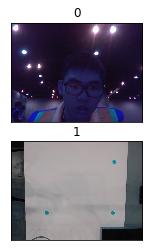

In [2]:
check_camera()

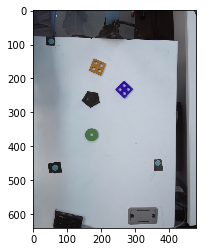

True

In [5]:
import iros_vision_tools as ivt
import numpy as np
import cv2
from matplotlib import pyplot as plt
#import imutils
import copy

CAMERA=0
PORTS=3
CAL_PARAM = {'thresh': [65,100],
            'radius': [4, 9]}
cali_img = ivt.capture_pic(0, 1)
#print cali_img
plt.imshow(cali_img)
plt.show()
cv2.imwrite("cali_img.jpg",cali_img)

{'radius': [8, 10], 'thresh': [125, 160]}
18
All Calibration points found


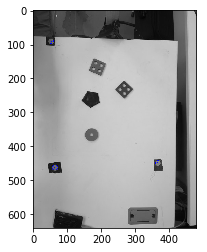

[[[  53.5          91.5           8.51469326]
  [  64.5         462.5           8.63133812]
  [ 365.5         448.5           8.63133812]]]


In [6]:
import iros_vision_tools as ivt


cali_img = cv2.imread("cali_img.jpg")
CAL_PARAM = {'thresh': [125, 160],
            'radius': [8,10]}
circles, cimg = ivt.find_circles(copy.copy(cali_img), 3, param=CAL_PARAM, blur=1, show=False)
plt.imshow(cimg)
plt.show()
circles_sorted, crop_points = ivt.sort_circles3(circles)
print circles_sorted

In [7]:
cali_circles_init = circles_sorted-circles_sorted[0][0]
cali_circles=[]
for circ in cali_circles_init[0]:
    cali_circles.append([circ[0], circ[1]])

print cali_circles

p1, inverse =ivt.pix3world_cal(cali_circles[0],cali_circles[2], cali_circles[1])

[[0.0, 0.0], [11.0, 371.0], [312.0, 357.0]]


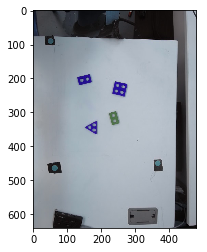

True

In [41]:
test_img = ivt.capture_pic(0,1)
plt.imshow(test_img)
plt.show()
cv2.imwrite("test_img4.jpg", test_img)

(640, 480, 3)


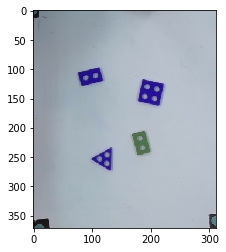

In [42]:
print np.shape(test_img)

img = ivt.crop_out(test_img, crop_points)
plt.imshow(img)
plt.show()

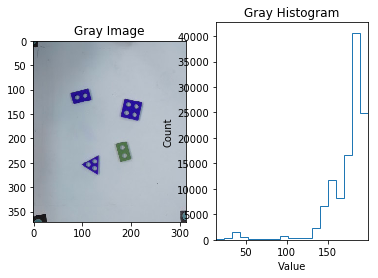

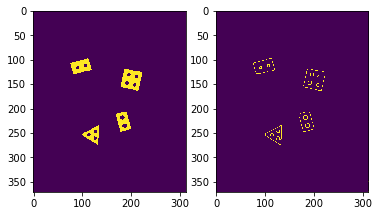

Too small
Too small


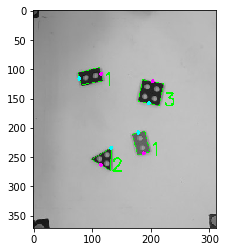

In [43]:
from numpy import linalg

def extract_shape_contours(image, threshold=120, show=True):
    img = copy.copy(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_flat = gray[np.isfinite(gray)]
    black, white = np.min(gray_flat), np.max(gray_flat)
    if show:
        plt.figure('Gray Image and Histogram')
        
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Gray Image')
        
        plt.subplot(1,2,2)
        plt.hist(gray_flat, bins=np.linspace(black,white, 20), histtype='step')
        plt.xlim(black, white)
        plt.title('Gray Histogram')
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.show()
        
    gray_mask = np.zeros_like(gray)
    gray_mask[gray<threshold] = 250
    gray_mask[-20:-1,:] = 0
    gray_mask[:, 0:30] = 0
    gray_mask[:, -20:-1] = 0
    
    
    edged, edg_img, cnts, hierarchy=ivt.extract_contours(gray_mask, 
                                                         min_thresh=60, max_thresh=250, 
                                                         blur=3, dilate=1, erode=1, 
                                                         cnt_mode=cv2.RETR_EXTERNAL)
    
    if show:
        plt.figure("Extracted Shapes")
        plt.subplot(1,2,1)
        plt.imshow(gray_mask)
        plt.subplot(1,2,2)
        plt.imshow(edged)
        plt.show()
    
    return cnts, hierarchy

def extract_shape_list(image, threshold, show=True):
    cnts, hierarchy = extract_shape_contours(image, threshold=threshold, show=show)
    
    show_img = copy.copy(image)
    show_img = cv2.cvtColor(show_img, cv2.COLOR_RGB2GRAY)
    show_img = cv2.cvtColor(show_img, cv2.COLOR_GRAY2RGB)
    shape_list = []
    
    for i,c in enumerate(cnts):
        shape_object = {}
        
        if hierarchy[0][i][3]!=-1:
            print "Not External shape"
            continue
        
        if cv2.contourArea(c) < 150:
            print "Too small"
            continue
        
        approx = detect(c)
        cmax = np.max(approx, axis = 0)
        cX, cY = cmax[0][0], cmax[0][1]
        
        cv2.drawContours(show_img, [approx], -1, (0,255,0), 1)
        
        # Find Shape Centre
        centre = np.mean(approx, axis=0)
        shape_object['centre']=centre

        if len(approx)==3:
            shape=2
            point1 = approx[0]
            point2 = (approx[1]+approx[2])/2
            direction = (point1-point2)/linalg.norm(point1-point2)
        elif len(approx)==4:
            vect1 = approx[0]-approx[1]
            vect2 = approx[1]-approx[2]
            
            len_side1 = linalg.norm(vect1)
            len_side2 = linalg.norm(vect2)
            long_side, short_side = 0,0
            if len_side1 > len_side2:
                long_side = len_side1
                short_side = len_side2
                direction = vect1/linalg.norm(vect1)
                point1 = (approx[1]+approx[2])/2
                point2 = (approx[3]+approx[0])/2
            else:
                long_side = len_side2
                short_side = len_side1
                direction = vect2/linalg.norm(vect2)
                point1 = (approx[0]+approx[1])/2
                point2 = (approx[2]+approx[3])/2

            aspect = float(long_side)/short_side

            if aspect < 1:
                aspect = 1/aspect
            if aspect>1.4:
                shape = 1
            else:
                shape = 3
                
        elif len(approx) == 5:
            shape = 4
            point1 = approx[0]
            point2 = (approx[2]+approx[3])/2
            direction = (point1-point2)/linalg.norm(point1-point2)
        else:
            shape = 0
            radius = centre - approx[0]
            direction = radius/linalg.norm(radius)
            point1 = centre - radius
            point2 = centre + radius
            
        dir_rat = direction[0][1]/-direction[0][0]
        angle = np.arctan(dir_rat)*180/np.pi
        
        shape_object['ratio']=dir_rat
        shape_object['angle'] = angle
        shape_object['shape']=shape
        shape_object['approx']=approx
        shape_object['point1']=point1
        shape_object['point2']=point2
        cv2.circle(show_img, (int(point1[0][0]), int(point1[0][1])), 2, (0,255,255),2)
        cv2.circle(show_img, (int(point2[0][0]), int(point2[0][1])), 2, (255,0,255),2)
        cv2.putText(show_img, str(shape), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        shape_list.append(shape_object)
    if show:
        plt.figure("Labelled Shapes")
        plt.imshow(show_img)
        plt.show()
    return shape_list
                
shape_list = extract_shape_list(img, threshold=120, show=True)

In [39]:
shape_list[1]

{'angle': 62.300527191945001, 'approx': array([[[143, 210]],
 
        [[117, 214]],
 
        [[110, 238]],
 
        [[134, 262]],
 
        [[159, 240]]], dtype=int32), 'centre': array([[ 132.6,  232.8]]), 'point1': array([[143, 210]], dtype=int32), 'point2': array([[122, 250]], dtype=int32), 'ratio': 1.9047619047619049, 'shape': 4}

In [25]:
image_flat = img[np.isfinite(img)]
black, white = np.percentile(image_flat, 5), np.percentile(image_flat, 95)
black, white = np.min(image_flat), np.max(image_flat)

# Create the figure.
plt.figure(figsize=(14, 5))

# Show the image.
plt.subplot(1, 2, 1)
plt.imshow(test_imgimg)
plt.axis('off')
plt.title('Image')

# Show the histogram
plt.subplot(1, 2, 2)
gray = cv2.cvtColor(copy.copy(img), cv2.COLOR_RGB2GRAY)
gray_flat = gray[np.isfinite(gray)]
black, white = np.percentile(gray_flat, 5), np.percentile(gray_flat, 95)
black, white = np.min(gray_flat), np.max(gray_flat)
plt.hist(gray_flat, bins=np.linspace(black, white, 255), histtype='step')
plt.xlim(black, white)
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

gray_mask = np.zeros_like(gray)
gray_mask[gray<120] = 250
gray_mask[-30:-1,:] = 0
gray_mask[:, 0:30]=0
gray_mask[:, -20:-1]=0
plt.imshow(gray_mask)
plt.show()

NameError: name 'test_imgimg' is not defined

In [100]:
edged, edg_img, cnts, hierarchy=ivt.extract_contours(gray_mask, min_thresh=60, max_thresh=250, blur=3, dilate=1, erode=1, cnt_mode=cv2.RETR_EXTERNAL)

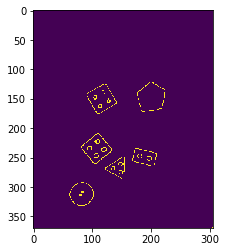

In [101]:
plt.imshow(edged)
plt.show()

In [102]:
np.shape(cnts)

(7,)

In [12]:
def detect(c):
    # initialize the shape name and approximate the contour

    shape = "unidentified"
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.03 * peri, True)
    return approx

Too small
8
[[  83.     311.375]]
[[ 0.1026802   0.99471442]]
3
[[-0.99954118  0.03028913]]
4
[[-0.97618706 -0.21693046]]
4
[[ 0.806405   -0.59136366]]
4
[[-0.45795659 -0.88897456]]
5
[[ 0.91806235 -0.39643602]]


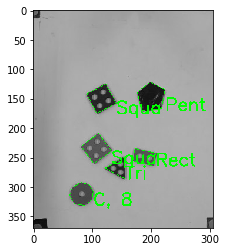

6


In [104]:
from scipy.spatial.distance import cdist

show_img = copy.copy(test_imgimg)
show_img = cv2.cvtColor(show_img, cv2.COLOR_RGB2GRAY)
show_img = cv2.cvtColor(show_img, cv2.COLOR_GRAY2RGB)
num = 0
shape="unknown"
shape_list = []

#print np.shape(show_img)
for i,c in enumerate(cnts):
    
    shape_object = {}
    
    if hierarchy[0][i][3]!=-1:
        print "Not external"
        continue
    
    if cv2.contourArea(c) < 150:
        print "Too small"
        continue
    approx = detect(c)    
    cmax = np.max(approx, axis=0)
    cX, cY = cmax[0][0], cmax[0][1]
    cv2.drawContours(show_img, [approx], -1, (0, 255, 0), 1)
    num+=1
    
    # Find shape centre:
    centre=np.mean(approx, axis=0)
    shape_object['centre']=centre
    
    print len(approx)
    if len(approx)==3:
        shape = "Tri"
        point1 = approx[0]
        point2 = (approx[1]+approx[2])/2
        direction = (point1-point2)/LA.norm(point1-point2)
        
    elif len(approx) == 4:
        
        vect1 = approx[0]-approx[1]
        vect2 = approx[1]-approx[2]

        len_side1 = cdist(approx[0], approx[1])
        len_side2 = cdist(approx[1], approx[2])
        
        long_side, short_side = 0,0
        
        if len_side1 > len_side2:
            long_side = len_side1
            short_side = len_side2
            direction = vect1/LA.norm(vect1)
        else:
            long_side = len_side2
            short_side = len_side1
            direction = vect2/LA.norm(vect2)
            
        aspect = float(long_side)/short_side
        
        if aspect < 1:
            aspect = 1/aspect
        if aspect>1.4:
            shape = "Rect"
        else:
            shape = "Squa"

    elif len(approx) == 5:
        shape = "Pent"
        point1 = approx[0]
        point2 = (approx[2]+approx[3])/2
        direction = (point1-point2)/LA.norm(point1-point2)
    else:
        shape = "C, "+str(len(approx))
        print centre
        radius = centre - approx[0]
        direction = radius/LA.norm(radius)
    
    dir_rat = direction[0][0]/direction[0][1]
    print direction

    angle = np.arctan(dir_rat)*180/np.pi
    shape_object['angle'] = angle
    shape_object['shape']=shape
    shape_object['approx']=approx
    
    cv2.putText(show_img, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    shape_list.append(shape_object)
plt.imshow(show_img)
plt.show()
print num

In [106]:
print hierarchy

[[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [ 3  1 -1 -1]
  [ 4  2 -1 -1]
  [ 5  3 -1 -1]
  [ 6  4 -1 -1]
  [-1  5 -1 -1]]]


In [69]:
def undistort_height(pix, height, crop_points):
    w2p_height_ratio = 370.0/493
    pix_height = w2p_height_ratio*700
    
    obj_height = height*w2p_height_ratio
    
    x = ((319.5-crop_points[0])-pix[0])
    tan_alpha_x = x/pix_height
    dx = tan_alpha_x*obj_height
    
    y = ((239.5-crop_points[2])-pix[1])
    tan_alpha_y = y/pix_height
    dy = tan_alpha_y*obj_height
    
    pix[0] = pix[0]+dx
    pix[1] = pix[1]+dy
    return pix
    

In [70]:
undistort_height([50,130], 40, crop_points)

[60.285714285714285, 132.45714285714286]

In [205]:
edged, edg_img, cnts, hierarchy=vt.extract_contours(copy.copy(img), min_thresh=25, max_thresh=40, blur = 5, dilate=1, erode=0, cnt_mode = cv2.RETR_TREE)

NameError: name 'vt' is not defined

7
2
{'cup': {'num_circles': 1, 'circle': array([ 140.5       ,  286.5       ,   44.79397202], dtype=float32), 'id': 1}, 'saucer': {'num_circles': 6, 'circle': array([ 306.5       ,  314.5       ,   41.30980682], dtype=float32), 'id': 0}}


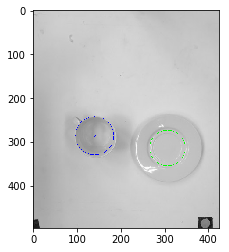

In [106]:
from scipy.spatial.distance import cdist

print len(circles[0])
print len(circles2[0])

table_circles = {}
store = []
for j,i in enumerate(circles2[0]):
    circle_info = {}
    circle_info["id"] = j
    coords = np.array([i[:-1]])
    radius = i[-1]
    circle_info["circle"]=i
    num = 0
    for k in (circles[0]):
        #print np.array([k[:-1]])
        if cdist(np.array([k[:-1]]),coords)<radius:
            num = num+1
    circle_info["num_circles"]=num
    store.append(circle_info)
for member in store:
    if member["num_circles"]>3:
        color = (0,255,0)
        table_circles["saucer"]=member
    else:
        color = (0,0,255)
        table_circles["cup"]=member
    
    cv2.circle(cimg,(int(member["circle"][0]),int(member["circle"][1])),int(member["circle"][2]),color,1)
                # draw the center of the ci~rcle
    cv2.circle(cimg,(int(member["circle"][0]),int(member["circle"][1])),2,color,1)

print table_circles
plt.imshow(cimg)
plt.show()

In [58]:
import os
cv2.imwrite(os.path.join("task_images", 'test.jpg'), test_img)

True

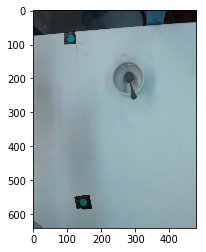

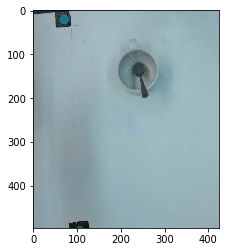

In [198]:
test_img = capture_pic(1,1)
plt.imshow(test_img)
plt.show()
cv2.imwrite("test_img5.jpg", test_img)#

img = vt.crop_out(test_img, crop_points)
plt.imshow(img)
plt.show()

In [199]:
test_img = copy.copy(img)

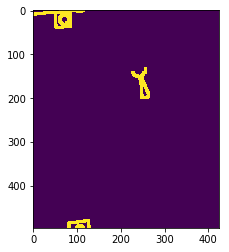

In [223]:
plt.imshow(edged)
plt.show()

{'radius': [30, 45], 'thresh': [75, 100]}
37
All Calibration points found
(59, 1, 2)
(59, 2)
DISTANCE:  361.608213402
MINDISTANCE:  1000
BOX:  [[ 77 495]
 [ 77 477]
 [131 477]
 [131 495]]
BOX TOO SMALL:  972
(87, 1, 2)
(87, 2)
DISTANCE:  16.3248277173
MINDISTANCE:  361.608213402
BOX:  [[231 206]
 [222 133]
 [258 129]
 [267 202]]
(26, 1, 2)
(26, 2)
('Object at #[[249 173]] REJECTED because not big enough: ', 126.5)
(48, 1, 2)
(48, 2)
DISTANCE:  225.504988858
MINDISTANCE:  16.3248277173
Too far:  [[ 225.50498886  225.70002215  245.31714168  245.60232084  254.0285417
   254.35113524  261.19437207  261.546363    270.21565462  270.60025868
   271.47467654  268.61961954  262.4509478   262.05438367  253.34265334
   252.97924816  246.10262087  245.76920067  237.3025495   237.00738385
   232.83577904  230.06194818  225.72660455  224.34905839  214.91975247
   213.57083134  212.65582522  211.31138161  193.68143948  193.30933759
   183.00956259  182.69236437  180.16242672  179.58424207  194.552049

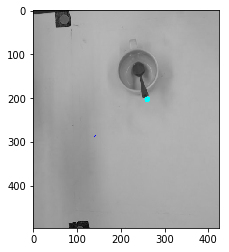

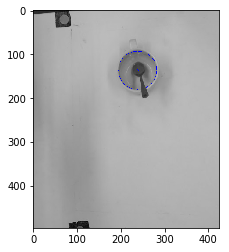

In [242]:

def extract_minBox(contour):
    box = cv2.minAreaRect(contour)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    return box

def draw_minBox(image, box):
    img = copy.copy(image)
    cv2.drawContours(img, [box], -1, (0,255,0), 4)
    #plt.figure()
    #plt.imshow(img)
    return img

def farthest_node(node, nodes):
    return nodes[cdist([node], nodes).argmax()], cdist([node], nodes).argmax()


def find_spoon(image, show=True):
    img = copy.copy(image)
    edged, edg_img, cnts, hierarchy=vt.extract_contours(copy.copy(img), 
                                                        min_thresh=25, 
                                                        max_thresh=240, 
                                                        blur = 5, dilate=3, erode=0, 
                                                        cnt_mode = cv2.RETR_TREE)
    CAL_PARAM = {'thresh': [75, 100],
                 'radius': [30,45]}
    minsize=500
    mindistance = 1000
    box_minsize = 1200
    
    circles, cimg = vt.find_circles(copy.copy(img), 0, param=CAL_PARAM, blur=1, show=False)

    show_img = copy.copy(img)
    show_img = cv2.cvtColor(show_img, cv2.COLOR_RGB2GRAY)
    show_img = cv2.cvtColor(show_img, cv2.COLOR_GRAY2RGB)
    
    for cnt in cnts:
        current_outer_contour = []
        for points in cnt:
            current_outer_contour.append(points[0])

        distance = cdist(np.array([[circles[0][0][0],circles[0][0][1]]]),current_outer_contour)

        if cv2.contourArea(cnt) < minsize:
            print("Object at #{} REJECTED because CONTOUR not big enough: ".format(cnt[0]), cv2.contourArea(cnt))
            continue

        if distance[0][0] > mindistance:
            print("Object at #{} REJECTED because not CLOSE ENOUGH: ".format(cnt[0]), distance[0][0])
            continue
        mindistance = distance[0][0]

        box = extract_minBox(cnt)
        box_area = abs((box[0][0]-box[2][0])*(box[1][1]-box[0][1]))
        
        if box_area < box_minsize:
            print("Object at #{} REJECTED because BOX not big enough: ".format(cnt[0]), box_area)
            continue
        fnode = farthest_node([circles[0][0][0],circles[0][0][1]], current_outer_contour)

    print "FNODE: ", fnode
    print "CIRCLE:", circles
    cv2.circle(show_img,(int(member["circle"][0]),int(member["circle"][1])),2,color,1)
    cv2.circle(show_img, (fnode[0][0], fnode[0][1]), 3, (0,255,255),5)
    
    if show:
        plt.imshow(show_img)
        plt.figure()
        plt.imshow(cimg)
        plt.show()
    return circles[0], fnode 





CAL_PARAM = {'thresh': [75, 100],
            'radius': [30,45]}

circles, cimg = vt.find_circles(copy.copy(img), 0, param=CAL_PARAM, blur=1, show=False)

show_img = copy.copy(img)
show_img = cv2.cvtColor(show_img, cv2.COLOR_RGB2GRAY)
show_img = cv2.cvtColor(show_img, cv2.COLOR_GRAY2RGB)
minsize=500
mindistance = 1000
box_minsize = 1200
for cnt in cnts:
    print np.shape(cnt)
    
    current_outer_contour = []
    for points in cnt:
        current_outer_contour.append(points[0])
    
    print np.shape(current_outer_contour)
    distance = cdist(np.array([[circles[0][0][0],circles[0][0][1]]]),current_outer_contour)

    if cv2.contourArea(cnt) < minsize:
        print("Object at #{} REJECTED because not big enough: ".format(cnt[0]), cv2.contourArea(cnt))
        continue
    print "DISTANCE: ", distance[0][0]
    print "MINDISTANCE: ", mindistance
    if distance[0][0] > mindistance:
        print "Too far: ", distance
        continue
    mindistance = distance[0][0]
    
    box = extract_minBox(cnt)
    print "BOX: ", box
    box_area = abs((box[0][0]-box[2][0])*(box[1][1]-box[0][1]))
    if box_area < box_minsize:
        print "BOX TOO SMALL: ", box_area
        continue
    fnode = farthest_node([circles[0][0][0],circles[0][0][1]], current_outer_contour)

print "FNODE: ", fnode
print "CIRCLE:", circles
cv2.circle(show_img,(int(member["circle"][0]),int(member["circle"][1])),2,color,1)
cv2.circle(show_img, (fnode[0][0], fnode[0][1]), 3, (0,255,255),5)

plt.imshow(show_img)
plt.figure()
plt.imshow(cimg)
plt.show()

{'radius': [30, 45], 'thresh': [75, 100]}
37
All Calibration points found
('Object at #[[114 477]] REJECTED because BOX not big enough: ', 972)
('Object at #[[249 173]] REJECTED because CONTOUR not big enough: ', 126.5)
('Object at #[[59  1]] REJECTED because not CLOSE ENOUGH: ', 225.50498885833989)
('Object at #[[70 14]] REJECTED because CONTOUR not big enough: ', 130.0)
('Object at #[[53 10]] REJECTED because CONTOUR not big enough: ', 121.5)
('Object at #[[60  9]] REJECTED because CONTOUR not big enough: ', 2.0)
FNODE:  (array([260, 203], dtype=int32), 48)
CIRCLE: [[[ 238.5         137.5          44.57016754]]]


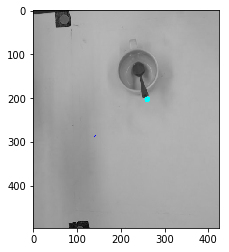

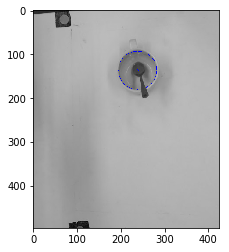

(array([[ 238.5       ,  137.5       ,   44.57016754]], dtype=float32),
 (array([260, 203], dtype=int32), 48))

In [243]:
find_spoon(img)

In [52]:
a=np.array([[3,4], [6,8]])
linalg.norm(a, axis=1)
print a

[[3 4]
 [6 8]]


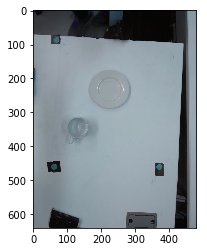

True

In [268]:
cali_img = ivt.capture_pic(0,1)
plt.imshow(cali_img)
plt.show()
cv2.imwrite("cali_img.jpg", cali_img)

{'radius': [8, 10], 'thresh': [125, 160]}
18
All Calibration points found


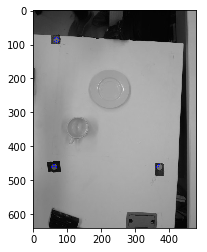

In [269]:
cali_img = cv2.imread("cali_img.jpg")
CAL_PARAM = {'thresh': [125, 160],
            'radius': [8,10]}
circles, cimg = ivt.find_circles(copy.copy(cali_img), 3, param=CAL_PARAM, blur=1, show=False)
plt.imshow(cimg)
plt.show()
circles_sorted, crop_points = ivt.sort_circles3(circles)

In [270]:
print circles_sorted
print circles_sorted[:,:,:2]-circles_sorted[:,:,:2][0][0]
linalg.norm(circles_sorted-circles_sorted[0][0], axis=2)

[[[  68.5          87.5           8.51469326]
  [  61.5         460.5           8.63133812]
  [ 368.5         460.5           8.63133812]]]
[[[   0.    0.]
  [  -7.  373.]
  [ 300.  373.]]]


array([[   0.        ,  373.0656961 ,  478.67422492]])

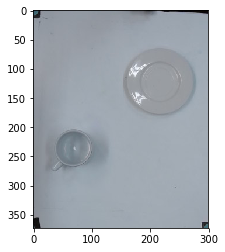

In [272]:

test_img = ivt.capture_pic(0,1)
cv2.imwrite("test_img5.jpg", test_img)

img = ivt.crop_out(test_img, crop_points)
plt.imshow(img)
plt.show()

In [278]:
def find_circles2(img, num_circles, param=CAL_PARAM, blur=3, overlap=True, separation=None, show=True):
    gray = copy.copy(img)
    if show:
        plt.imshow(gray)
        plt.show()
    if len(np.shape(gray))>2:
        gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    
    blurred_img = cv2.medianBlur(gray, blur)

    circles = None
    counter = 0
    #plt.imshow(blurred_img)
    print param
    old_circles = None

    while counter < param['thresh'][0]-1 :
        #print (counter)
        circles = cv2.HoughCircles(blurred_img.astype("uint8"), cv2.HOUGH_GRADIENT, 1, 20,
                                       param1=param['thresh'][1],
                                       param2=param['thresh'][0]-counter,
                                       minRadius = param['radius'][0],
                                       maxRadius = param['radius'][1])
        if old_circles is None:
            old_circles = circles
        if overlap is False and circles is not None:
            keep_circles = np.zeros_like(old_circles)
            new_circles = circles
            print "COUNTERR: ", counter
            for old_id, old_circle in enumerate(old_circles[0]):
                idx = []
                separation_list = linalg.norm(circles[:,:,:2]-[old_circle[:2]], axis=2)
                idx.append(np.argmin(separation_list))
                #print "old_new", np.shape(circles),np.shape(old_circles),separation_list
                keep_circles[0][old_id] = circles[0][idx]

            for circle in circles[0]:
                #print "circle",circle, "keep",keep_circles
                
                keep_separation = linalg.norm([[circle[:2]]]-keep_circles[:,:,:2], axis=2)
                #print "KEEP SEPERATION",keep_separation
                if (sum(np.greater(keep_separation[0],separation)) == keep_separation[0].size).astype(np.int):
                    print keep_separation
                    print circle
                    print (keep_separation > separation)
                    print "IT IS A COMPLETELY SEPARATE CIRCLE"
                    keep_circles = np.append(keep_circles, [[circle]], axis=1)
                
            circles = keep_circles        
            
        
        if circles is not None and len(circles[0])>num_circles-1:
            print separation
            print "new:",circles
            print param['thresh'][0]-counter
            print ('All Calibration points found')
            break
        
        if counter==param['thresh'][0] and len(circles[0])<num_circles:
            print "Found circles: ", circles
        old_circles = circles

        counter = counter + 1

    if circles is None:
        print ('No circles Detected, try changing param values')
        return None
    else:
        cimg = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
        #cimg = copy.copy(ir_img)
        for i in circles[0,:]:
                # draw the outer circle
            cv2.circle(cimg,(int(i[0]),int(i[1])),int(i[2]),(0,0,255),1)
                # draw the center of the ci~rcle
            cv2.circle(cimg,(int(i[0]),int(i[1])),2,(0,0,255),1)

        if show==True:
            cv2.imshow("Calibration Points Identified", cimg)
            cv2.imwrite("calibrated_image.jpg", cimg)
            if cv2.waitKey():# & 0xFF == ord('q'):
                print ("Quit")
            cv2.destroyAllWindows()
        return circles, cimg

In [284]:
CAL_PARAM = {'thresh': [30, 140],
                'radius': [30,45]}
circles2, cimg = find_circles2(copy.copy(img), 3, param=CAL_PARAM, overlap=False, separation=60, blur=1, show=False)

{'radius': [30, 45], 'thresh': [30, 140]}
COUNTERR:  0
COUNTERR:  1
COUNTERR:  2
COUNTERR:  3
COUNTERR:  4
COUNTERR:  5
COUNTERR:  6
COUNTERR:  7
COUNTERR:  8
COUNTERR:  9
COUNTERR:  10
[[ 183.04371643]]
[ 209.5         122.5          43.34166718]
[[ True]]
IT IS A COMPLETELY SEPARATE CIRCLE
COUNTERR:  11
COUNTERR:  12
COUNTERR:  13
COUNTERR:  14
COUNTERR:  15
COUNTERR:  16
COUNTERR:  17
COUNTERR:  18
COUNTERR:  19
COUNTERR:  20
COUNTERR:  21
COUNTERR:  22
[[  62.07253647  228.54759216]]
[  62.5         297.5          31.75688934]
[[ True  True]]
IT IS A COMPLETELY SEPARATE CIRCLE
60
new: [[[  65.5         235.5          30.70016289]
  [ 209.5         122.5          43.34166718]
  [  62.5         297.5          31.75688934]]]
8
All Calibration points found


In [263]:
sum(np.greater([a[0][0]], 1000))

array([0, 0, 0])

In [264]:
a = copy.copy(circles_sorted)
np.append(a, [[a[0][1]]], axis=1)

array([[[  27.5       ,   88.5       ,    8.63133812],
        [  46.5       ,  466.5       ,    8.63133812],
        [ 349.5       ,  445.5       ,    8.63133812],
        [  46.5       ,  466.5       ,    8.63133812]]])

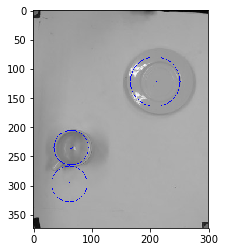

In [285]:
plt.imshow(cimg)
plt.show()

{'radius': [8, 10], 'thresh': [125, 160]}
8
All Calibration points found


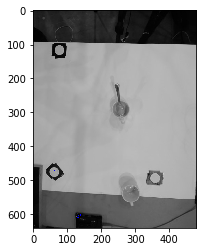

Change Calibration?: yes


UnboundLocalError: local variable 'CAL_PARAM' referenced before assignment

In [8]:
cali_img = ivt.capture_pic(1,3)
circles_sorted, crop_points = ivt.run_calibration(cali_img, adjust=True)

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
#import imutils
import copy

CAMERA=0
PORTS=3
CAL_PARAM = {'thresh': [65,100],
            'radius': [4, 9]}
ROTATION = 3

import iros_vision_tools as ivt
import iros_vision_functions as ivfunc



task_img_3 = ivt.capture_pic(CAMERA,ROTATION)


crop_task_img_3 = ivt.crop_out(task_img_3, crop_points)

img_3a = crop_task_img_3[80:280, 80:230]
plt.imshow(img_3a)
img_3b = ivt.black_out(crop_task_img_3, [180,-1,0,-1])
img_3b = crop_task_img_3
img_3b[100:280, 80:230]=[0,0,0]
plt.imshow(img_3b)
plt.show()

#p_circle, spoon = ivfunc.find_spoon(img_3a, show=True)

NameError: name 'crop_points' is not defined